In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digital-turbine-auction-bid-price-prediction/sample_submission.csv
/kaggle/input/digital-turbine-auction-bid-price-prediction/train_data.csv
/kaggle/input/digital-turbine-auction-bid-price-prediction/test_data.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/digital-turbine-auction-bid-price-prediction/train_data.csv')
test_df = pd.read_csv('/kaggle/input/digital-turbine-auction-bid-price-prediction/test_data.csv')

# imports

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime
from pytz import country_timezones

In [4]:
# dataframe info stats

def stats(data):
    
    maxx = []
    minn = []
    for i in data.columns:
        maxx.append(data[i].value_counts().max())
        minn.append(data[i].value_counts().min())

    return pd.DataFrame(
        {'nunique': data.nunique(),
         'len': len(data),
        # 'nunique/len': data.nunique()/len(data),
         'types':data.dtypes,
         'Nulls' : data.isna().sum(),
        # 'Nullpercent' : data.isna().sum()/len(data),
         "Value counts Max": maxx,
         'Value counts Min':minn 
        },
        columns = ['nunique', 'len','types','Nulls'#,'Nullpercent', 'nunique/len'
                   ,"Value counts Max",'Value counts Min']).\
        sort_values(by ='nunique',ascending = False)



def countPlot(col,num = 6,hue = None):
    sns.set(rc={'figure.figsize':(6,6)})
    ax = sns.countplot(x=col, data=train_df, hue = hue,
                   order=train_df[col].value_counts().iloc[:num].index)
    
    return plt.show()


def percentile80(x):
    return np.percentile(x,80)

def pivot_tbl(df,column,sort = 'count'):
    
    pivoted = df.pivot_table(index = [column], values = ['winBid'], 
               aggfunc = [np.min,np.max,np.mean, np.median, np.std,'count', percentile80])
    
    pivoted.columns = pivoted.columns.get_level_values(0)
    
    return pivoted.sort_values(sort,ascending=False)


def pl(df):
    return(print(len(df)))


## https://stackoverflow.com/questions/56799202/pandas-groupby-and-cumulative-mean-of-previous-rows-in-group

def mean_previous(df, Category, Order, Var):
    
    
    # Order the dataframe first 
    df.sort_values([Category, Order], inplace=True)

    # Calculate the ordinary grouped cumulative sum 
    # and then substract with the grouped cumulative sum of the last order
    csp = df.groupby(Category)[Var].cumsum() - df.groupby([Category, Order])[Var].cumsum()

    # Calculate the ordinary grouped cumulative count 
    # and then substract with the grouped cumulative count of the last order
    ccp = df.groupby(Category)[Var].cumcount() - df.groupby([Category, Order]).cumcount()

    return csp / ccp

In [5]:
train_df.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice,winBid,has_won
0,1656411567773,banner,LG,com.tilegarden.match3,1.8.22,LM-V405,US,74f9b473fad,Android-10.0,3G,cb2,6.0,6b,4.0,320x50,11.2.1,0.01,0.02,0.88,0
1,1656925395488,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,FR,6ad4c88b84e,Android-4.0,WIFI,7d3,6.0,6b,6.0,320x50,11.4.2,0.01,0.03,0.08,0
2,1656913751642,banner,Generic,com.loop.match3d,1245.35.0,Android 4.0,US,743b9849642,Android-4.0,WIFI,7d3,3.0,6b,3.0,320x50,11.4.3,0.01,0.02,1.72,0
3,1656656319103,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,GB,6ad933115b2,Android-4.0,WIFI,7d3,3.0,6b,5.0,320x50,11.4.2,0.01,0.06,0.21,0
4,1657429389462,interstitial,OPPO,com.loop.match3d,1245.35.0,CPH2127,ID,809f9785bb3,Android-11.0,WIFI,8bd,3.0,6b,3.0,320x480,11.4.3,0.01,0.16,1.91,0


In [6]:
# sent bid / win bid ratio
print((train_df['sentPrice']/train_df['winBid']).mean())
print((train_df['winBid']/train_df['sentPrice']).mean())

n=90
len(train_df[train_df['winBid']>n])
print(len(train_df[(train_df['winBid'] > 10) & (train_df['sentPrice']< 10)]))

print(len(train_df[(train_df['winBid'] >0 ) & (train_df['sentPrice'] > 10)]))

0.3589451424393645
63.60101244516536
475191
80870


In [7]:
stats(train_df)

,nunique,len,types,Nulls,Value counts Max,Value counts Min
eventTimestamp,7302171,7321633,int64,0,4,1
deviceId,40176,7321633,object,0,25150,1
winBid,23008,7321633,float64,0,371679,1
sentPrice,7521,7321633,float64,0,1527464,1
correctModelName,2568,7321633,object,0,1973042,1
countryCode,168,7321633,object,27,2822649,1
brandName,144,7321633,object,0,2088820,1
appVersion,101,7321633,object,0,2911851,2
osAndVersion,96,7321633,object,0,2034520,2
c1,50,7321633,object,0,3758421,155


In [8]:
test_df.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice
0,1657758857892,rewarded,Generic,com.loop.match3d,1245.35.0,Android 4 Tablet,US,6a0a94554cf,Android-4.0,3G,7b8,2.0,6b,2.0,768x1024,11.4.3,0.05,0.06
1,1657210707978,interstitial,Generic,com.loop.match3d,1245.35.0,Android 4.0,ZA,6a0b0e59f45,Android-4.0,WIFI,8bd,8.0,6b,6.0,320x480,11.4.3,0.01,0.16
2,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,13.0.02,Moto g(8) power lite,BR,6a0fa820c46,Android-10.0,WIFI,ea0,8.0,6b,9.0,320x480,11.0.0,0.05,0.06
3,1657386816882,interstitial,Huawei,com.tintash.nailsalon,1.3.6,JDN2-AL00HN,IQ,6a142bdbea2,Android-9.0,WIFI,3dc,6.0,6b,4.0,768x1024,11.3.3,0.01,0.05
4,1657211600823,banner,Generic,com.tilegarden.match3,1.8.52,Android 4.0,US,6a16943a771,Android-4.0,WIFI,cb2,7.0,6b,5.0,320x50,11.4.3,0.01,0.03


In [9]:
stats(test_df)

,nunique,len,types,Nulls,Value counts Max,Value counts Min
deviceId,41586,41586,object,0,1,1
eventTimestamp,41584,41586,int64,0,2,1
correctModelName,2614,41586,object,0,7720,1
sentPrice,1789,41586,float64,0,7035,1
countryCode,170,41586,object,6,10411,1
brandName,149,41586,object,0,9374,1
appVersion,101,41586,object,0,8686,1
osAndVersion,97,41586,object,0,12440,1
c1,50,41586,object,0,5626,12
mediationProviderVersion,35,41586,object,0,19158,1


In [10]:
train_df.describe().T.applymap("{0:.3f}".format)

,count,mean,std,min,25%,50%,75%,max
eventTimestamp,7321633.000,1657044524161.089,396424337.518,1656290100421.000,1656710203520.000,1657043290386.000,1657388278715.000,1657758896986.000
c2,7321633.000,5.001,2.344,1.000,3.000,5.000,7.000,9.000
c4,7321633.000,4.999,2.345,1.000,3.000,5.000,7.000,9.000
bidFloorPrice,7321633.000,0.018,0.132,0.010,0.010,0.010,0.010,5.000
sentPrice,7321633.000,0.581,3.808,0.010,0.020,0.040,0.170,970.410
winBid,7321633.000,4.185,20.695,0.010,0.090,0.510,1.540,3405.720
has_won,7321633.000,0.111,0.314,0.000,0.000,0.000,0.000,1.000


In [11]:
test_df.describe().T.applymap("{0:.3f}".format)

,count,mean,std,min,25%,50%,75%,max
eventTimestamp,41586.000,1657183858623.452,433911203.563,1656290212593.000,1656819550846.000,1657244049935.000,1657586309226.500,1657758899048.000
c2,41586.000,5.009,2.350,1.000,3.000,5.000,7.000,9.000
c4,41586.000,5.008,2.346,1.000,3.000,5.000,7.000,9.000
bidFloorPrice,41586.000,0.060,0.412,0.010,0.010,0.010,0.050,5.000
sentPrice,41586.000,1.330,7.119,0.010,0.030,0.070,0.440,441.020


# Eda

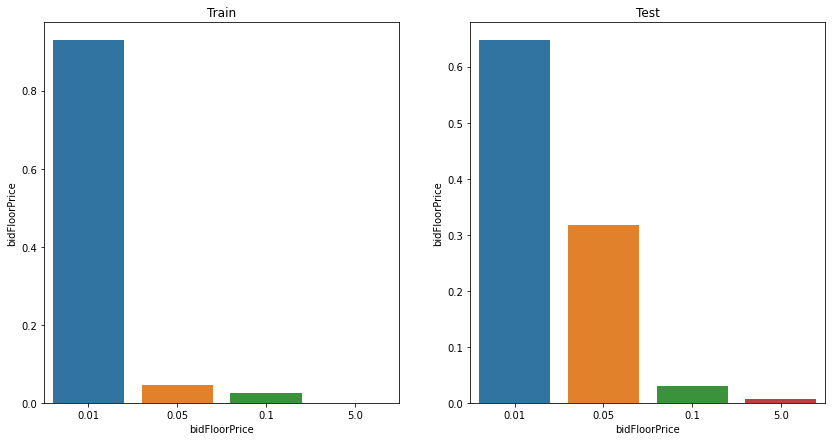

In [12]:
tr = train_df['bidFloorPrice'].value_counts(normalize=True)
ts = test_df['bidFloorPrice'].value_counts(normalize=True)

f= plt.figure(figsize=(14,7))

ax=f.add_subplot(121).set(xlabel='bidFloorPrice')
sns.barplot(x = tr.index,y=tr,).set_title("Train")

ax=f.add_subplot(122).set(xlabel='bidFloorPrice')
sns.barplot(x = ts.index,y=ts).set_title("Test");

In [13]:
pivot_tbl(train_df,'bidFloorPrice')

,amin,amax,mean,median,std,count,percentile80
bidFloorPrice,,,,,,,
0.01,0.01,3405.72,4.112358,0.48,20.841614,6797762,2.00
0.05,0.04,1012.34,6.709265,1.10,21.451493,333847,5.77
0.10,0.10,125.20,1.075051,0.85,1.073404,184991,1.60
5.00,5.00,675.53,48.622698,30.16,54.762492,5033,70.00


In [14]:
train_df[train_df['bidFloorPrice']>train_df['winBid']].head(2)

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,c2,c3,c4,size,mediationProviderVersion,bidFloorPrice,sentPrice,winBid,has_won
62873,1656860745231,banner,Samsung,com.loop.match3d,1245.34.0,SM-A226B,IN,746aedb4be2,Android-11.0,3G,7d3,1.0,6b,4.0,320x50,11.4.2,0.05,0.04,0.04,1
182046,1656750850931,banner,Samsung,com.loop.match3d,1245.34.0,SM-G610F,IN,7422186949a,Android-8.1.0,WIFI,7d3,5.0,6b,3.0,320x50,11.4.2,0.05,0.04,0.04,1


In [15]:
train_df[train_df['bidFloorPrice']>train_df['winBid']].shape

(73, 20)

In [16]:
print(len(train_df))
train_df = train_df[train_df['bidFloorPrice']<=train_df['winBid']]
print(len(train_df))


7321633
7321560


In [17]:
# # down sample to make dist same for ttest and train
# num_of_samples = (train_df['bidFloorPrice'].value_counts() / test_df['bidFloorPrice'].value_counts(normalize=True)).min()\
# *test_df['bidFloorPrice'].value_counts(normalize=True)
# # floats to ints
# num_of_samples = {k:int(v) for k, v in num_of_samples.iteritems()}
# num_of_samples

In [18]:
# sampled_train_df = train_df.groupby('bidFloorPrice').apply(lambda x: x.sample(num_of_samples[x.name],random_state=17)).reset_index(drop = True)
# print(sampled_train_df['bidFloorPrice'].value_counts(normalize=True))

In [19]:
#train_df = sampled_train_df

In [20]:
pivot_tbl(train_df,'deviceId','mean').head(10)

,amin,amax,mean,median,std,count,percentile80
deviceId,,,,,,,
7419b84da72,1012.34,1012.34,1012.340000,1012.34,NaN,1,1012.340
8022ebe4ca2,956.55,956.55,956.550000,956.55,NaN,1,956.550
80f6d4e891d,942.73,942.73,942.730000,942.73,0.000000,2,942.730
8000cf51c18,801.79,1245.01,923.250769,863.26,162.723117,13,1056.676
7488f520404,887.03,887.03,887.030000,887.03,0.000000,2,887.030
8082dbc9ce8,2.18,1283.90,828.420000,1283.90,631.837532,5,1283.900
740ded95297,75.00,2569.97,824.597463,617.93,743.182271,67,1016.360
744e4ce1351,363.31,1048.95,824.163486,787.50,158.556218,109,999.000
746b533d761,532.72,999.00,765.860000,765.86,329.709750,2,905.744


In [21]:
pivot_tbl(train_df,'c4')

,amin,amax,mean,median,std,count,percentile80
c4,,,,,,,
3.0,0.01,1172.34,4.185491,0.51,20.476310,915871,2.05
5.0,0.01,2506.77,4.153620,0.51,20.233873,915714,2.07
4.0,0.01,2198.79,4.156475,0.51,20.470212,915674,2.05
2.0,0.01,2527.12,4.183788,0.51,20.399090,914931,2.07
7.0,0.01,2767.72,4.222491,0.51,21.350261,914804,2.06
8.0,0.01,3405.72,4.201632,0.51,21.087170,914322,2.06
6.0,0.01,2282.33,4.182620,0.51,20.420073,914262,2.06
1.0,0.01,2391.55,4.200019,0.51,21.129327,458199,2.05
9.0,0.01,2527.12,4.182515,0.51,21.052672,457783,2.05


In [22]:
pivot_tbl(train_df,'c3')

,amin,amax,mean,median,std,count,percentile80
c3,,,,,,,
6b,0.01,3405.72,4.092533,0.57,20.525254,5832430,2.11
4b,0.01,2569.97,4.599169,0.36,21.755395,1303645,1.71
79,0.01,485.90,4.484776,0.46,21.308057,107368,1.90
4e,0.01,548.97,3.733727,0.53,12.600108,78117,2.65


In [23]:
pivot_tbl(train_df,'c2')

,amin,amax,mean,median,std,count,percentile80
c2,,,,,,,
4.0,0.01,1955.88,4.190886,0.51,20.626332,916845,2.07
5.0,0.01,2569.97,4.207296,0.51,21.060463,916317,2.07
6.0,0.01,1283.90,4.152083,0.51,20.145593,915607,2.05
2.0,0.01,2527.12,4.158842,0.51,20.343326,914914,2.05
3.0,0.01,1249.39,4.190162,0.51,20.431147,914602,2.06
8.0,0.01,2198.79,4.209041,0.51,21.061147,914601,2.07
7.0,0.01,2527.12,4.175297,0.51,20.880342,914572,2.06
9.0,0.01,1048.95,4.200351,0.51,20.425532,457871,2.05
1.0,0.01,3405.72,4.187058,0.51,21.536677,456231,2.05


In [24]:
pivot_tbl(train_df,'connectionType')

,amin,amax,mean,median,std,count,percentile80
connectionType,,,,,,,
WIFI,0.01,3405.72,3.919391,0.47,19.608113,5844882,1.96
3G,0.01,2767.72,5.183140,0.83,24.285530,1168311,2.87
UNKNOWN,0.01,2569.97,5.439004,0.49,25.305622,307701,2.28


In [25]:
pivot_tbl(train_df,'c1','std').head(15)

,amin,amax,mean,median,std,count,percentile80
c1,,,,,,,
7ca,0.01,1846.01,32.299284,10.380,78.111727,104280,33.662
707,0.49,1283.90,34.145836,13.975,74.394485,15164,36.820
466,0.01,1486.41,39.844422,28.110,62.005929,16717,50.900
313,0.02,1283.90,25.576493,10.080,61.865993,12644,27.518
ce2,0.01,1849.98,23.400010,7.050,58.372954,86304,25.000
fdc,0.02,3405.72,26.267159,10.000,52.899082,107148,28.886
82a,0.03,2569.97,20.480266,9.500,48.458811,99103,21.090
b22,0.05,924.19,15.276139,3.020,43.416986,10341,12.710
443,0.06,424.13,33.440217,22.595,43.194446,506,41.810


In [26]:
pivot_tbl(train_df,'countryCode','mean').head(15)

,amin,amax,mean,median,std,count,percentile80
countryCode,,,,,,,
TM,19.61,48.76,34.185000,34.185,20.612163,2,42.930
N/,0.03,89.66,22.626250,5.900,34.355195,8,41.536
LC,13.80,25.00,18.174615,17.840,3.451832,13,18.742
GU,5.40,45.01,17.856667,15.000,14.487389,15,21.994
NO,0.01,752.22,14.140419,4.580,42.642586,8141,19.970
SI,0.01,162.09,12.720155,0.450,31.730030,1163,6.156
IS,0.02,45.01,10.500631,10.000,9.218028,206,15.000
NZ,0.01,999.00,9.137600,0.180,44.240053,14038,3.742
FJ,0.69,136.80,8.914000,2.130,27.323261,35,5.000


In [27]:
pivot_tbl(train_df,'countryCode','std').head(15)

,amin,amax,mean,median,std,count,percentile80
countryCode,,,,,,,
NZ,0.01,999.00,9.137600,0.180,44.240053,14038,3.742
NO,0.01,752.22,14.140419,4.580,42.642586,8141,19.970
N/,0.03,89.66,22.626250,5.900,34.355195,8,41.536
SI,0.01,162.09,12.720155,0.450,31.730030,1163,6.156
US,0.01,3405.72,7.029587,1.110,28.964468,2822649,3.450
FJ,0.69,136.80,8.914000,2.130,27.323261,35,5.000
AU,0.01,2072.89,6.790936,0.500,26.668236,140159,4.620
CA,0.01,1084.01,4.555101,0.510,23.964473,295789,2.100
SE,0.01,538.13,6.762418,1.215,22.825637,11426,9.590


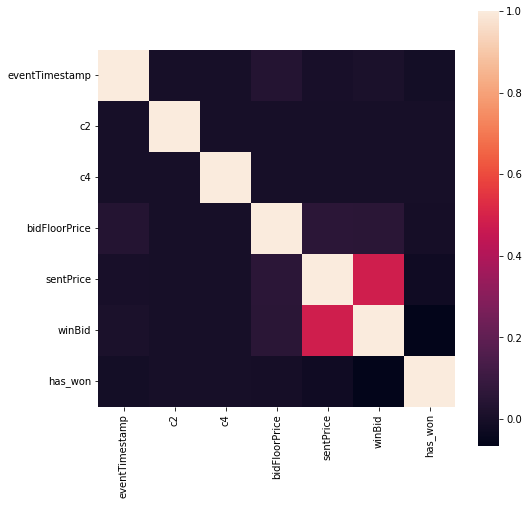

In [28]:
f, ax = plt.subplots(figsize=(8, 8))
corr = train_df.corr()
sns.heatmap(corr,square=True, ax=ax);

In [29]:
# f, ax = plt.subplots(figsize=(8, 8))
# corr = sampled_train_df.corr()
# sns.heatmap(corr,square=True, ax=ax);

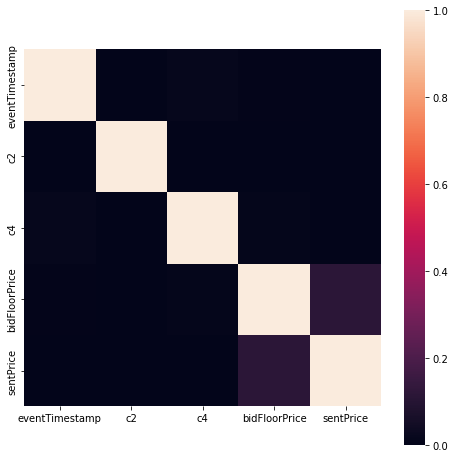

In [30]:
f, ax = plt.subplots(figsize=(8, 8))
corr = test_df.corr()
sns.heatmap(corr,square=True, ax=ax);

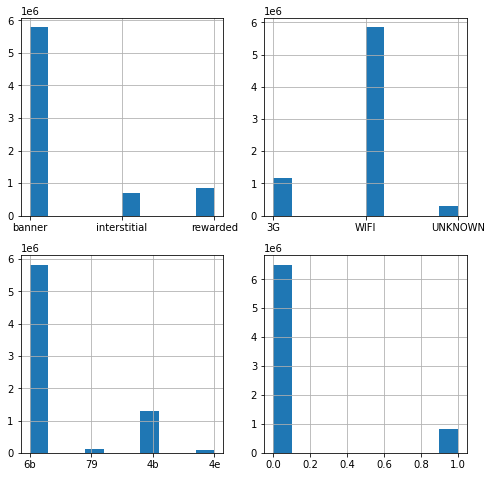

In [31]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()
train_df['unitDisplayType'].hist(figsize = (8, 8),ax=axes[0])
train_df['connectionType'].hist(figsize = (8, 8),ax=axes[1])
train_df['c3'].hist(figsize = (8, 8),ax=axes[2])
train_df['has_won'].hist(figsize = (8, 8),ax=axes[3])


plt.show()

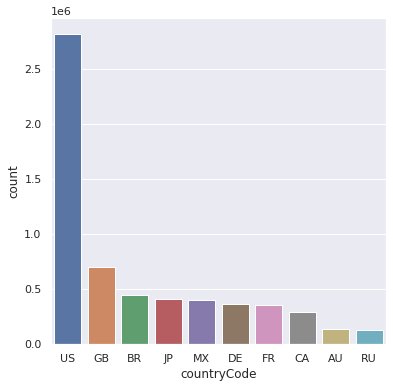

In [32]:
countPlot('countryCode',10)

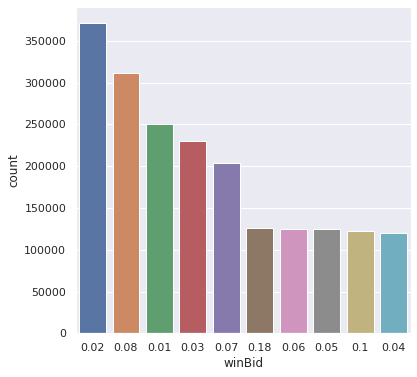

In [33]:
countPlot('winBid',10)

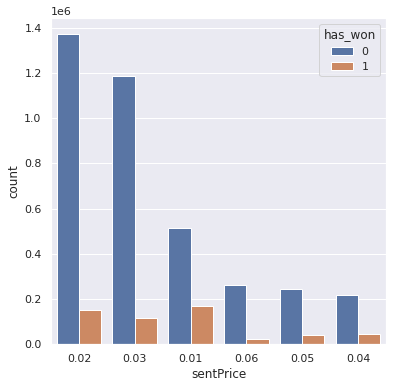

In [34]:
countPlot('sentPrice',6,'has_won')

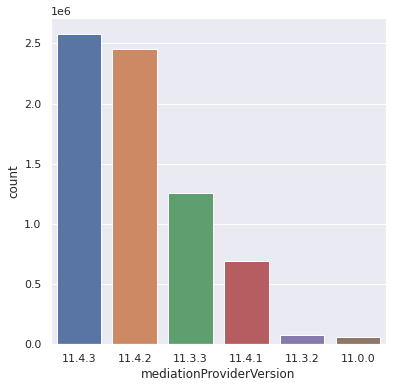

In [35]:
countPlot('mediationProviderVersion')

# preprocessing

In [36]:
# Q&D
# try with missing

# train_df.fillna({'countryCode':'US', 'connectionType':'UNKNOWN'}, inplace=True)
# test_df.fillna({'countryCode':'US', 'connectionType':'UNKNOWN'}, inplace=True)

train_df.fillna({'countryCode':'missing', 'connectionType':'missing'}, inplace=True)
test_df.fillna({'countryCode':'missing', 'connectionType':'missing'}, inplace=True)
                                    

In [37]:
cols = ['c2', 'c4']
train_df[cols] = train_df[cols].applymap(np.int8)
test_df[cols] = test_df[cols].applymap(np.int8)


floatcols = ['sentPrice', 'bidFloorPrice']

train_df['winBid'] = train_df['winBid'].astype(np.float16)

train_df[floatcols] = train_df[floatcols].applymap(np.float16)
test_df[floatcols] = test_df[floatcols].applymap(np.float16)



In [38]:
test_df['isTest'] = 1
test_df['winBid'] = np.nan
test_df['has_won'] = np.nan

train_df['isTest'] = 0

df = pd.concat([train_df, test_df])

In [39]:
print(test_df.shape)
print(train_df.shape)
print(df.shape)

(41586, 21)
(7321560, 21)
(7363146, 21)


In [40]:
del train_df,test_df

import gc

gc.collect()


25177

# TODO Feature eng 

In [41]:
%%time


def toLocalTime_pd(row): 
    return row['date'].tz_convert(country_timezones(row['countryCode'])[0]).replace(tzinfo=None)


df['date'] = pd.to_datetime(df['eventTimestamp'], unit='ms').dt.tz_localize('UTC')



#df['Local_date'] = df. apply(lambda r: toLocalTime_pd(r), axis=1)

CPU times: user 100 ms, sys: 1.01 ms, total: 101 ms
Wall time: 102 ms


In [42]:
%%time

feat = ['date','Local_date']
feat = ['date']


for f in feat:
    print(f)
    df[f+ '_weekday'] = df[f].dt.weekday
    df[f+ '_hour'] = df[f].dt.hour
    df[f+ '_minute'] = df[f].dt.minute
    df[f+ '_second'] = df[f].dt.second
    

    cond = [df[f+ '_hour']<8 ,
            df[f+ '_hour']<13,
            df[f+ '_hour']<18,
            df[f+ '_hour']<=24
           ]
    
    choice = ['morning','noon','afternoon','night']
    
    df[f+'_POD'] = np.select(cond, choice,np.nan)

date
CPU times: user 4.02 s, sys: 1.23 s, total: 5.25 s
Wall time: 5.22 s


In [43]:
%%time
# aggregated features

cols = ['sentPrice','countryCode','osAndVersion','brandName','appVersion','mediationProviderVersion','bundleId','deviceId',
       'unitDisplayType','correctModelName','c1', 'c2', 'c3', 'c4', 'size','connectionType','bidFloorPrice'
       ]

#cols = ['c1','sentPrice']

for c in cols:
    df[c + '_cummulative_mean'] = mean_previous(df, c, 'eventTimestamp', 'winBid')
    df.fillna({c + '_cummulative_mean':0}, inplace=True)

# TODO last n mean 
# df['appVersion_cummax'] = df.groupby('appVersion')['winBid'].cummax()

CPU times: user 7min 4s, sys: 45.8 s, total: 7min 50s
Wall time: 7min 51s


In [44]:

test_df = df[df['isTest'] == 1]
train_df = df[df['isTest'] == 0]

del df
gc.collect()


99

In [45]:
train_df.head()

,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,...,deviceId_cummulative_mean,unitDisplayType_cummulative_mean,correctModelName_cummulative_mean,c1_cummulative_mean,c2_cummulative_mean,c3_cummulative_mean,c4_cummulative_mean,size_cummulative_mean,connectionType_cummulative_mean,bidFloorPrice_cummulative_mean
2135494,1656290100421,banner,Generic,com.loop.match3d,1245.34.0,Android 11.0,MX,6a6860a0db6,Android-11.0,WIFI,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4036246,1656290102251,banner,Huawei,com.loop.match3d,1245.34.0,WAS-LX1A,PT,74efad94ff6,Android-8.0.0,WIFI,...,0.0,1.200195,0.0,1.200195,0.000000,1.200195,0.000000,1.200195,1.200195,1.200195
3570100,1656290103996,banner,Generic,com.loop.match3d,1245.34.0,Android 4.0,US,6a5e4097f8f,Android-4.0,3G,...,0.0,0.634766,0.0,0.634766,0.000000,0.634766,0.000000,0.634766,0.000000,0.634766
6901181,1656290104021,banner,Samsung,com.loop.match3d,1245.32.0,SM-A136U,US,8047e3a8d32,Android-11.0,3G,...,0.0,0.809896,0.0,0.809896,0.070312,0.809896,0.000000,0.809896,1.161133,0.809896
1747109,1656290104741,rewarded,Samsung,com.loop.match3d,1245.34.0,SM-A207M,EC,80e7472a820,Android-10.0,WIFI,...,0.0,0.000000,0.0,0.000000,0.669922,1.075195,1.160156,0.000000,0.483398,1.075195


# select columns

In [46]:
train_columns = [ 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode', 'deviceId',
       'osAndVersion', 'connectionType', 'c1', 'c2', 'c3', 'c4', 'size',
       'mediationProviderVersion', 'bidFloorPrice','sentPrice',#,'has_won'
                 
        'date_weekday', 'date_hour', 'date_minute',
       'date_second', 'date_POD',
                 
        'sentPrice_cummulative_mean',
       'countryCode_cummulative_mean', 'osAndVersion_cummulative_mean',
       'brandName_cummulative_mean', 'appVersion_cummulative_mean',
       'mediationProviderVersion_cummulative_mean',
       'bundleId_cummulative_mean', 'deviceId_cummulative_mean',
       'unitDisplayType_cummulative_mean', 'correctModelName_cummulative_mean',
       'c1_cummulative_mean', 'c2_cummulative_mean', 'c3_cummulative_mean',
       'c4_cummulative_mean', 'size_cummulative_mean',
       'connectionType_cummulative_mean', 'bidFloorPrice_cummulative_mean'
       ]

cat_columns = [ 'unitDisplayType', 'brandName', 'bundleId',
       'appVersion', 'correctModelName', 'countryCode', 'deviceId',
       'osAndVersion', 'connectionType', 'c1', 'c2', 'c3', 'c4', 'size',
       'mediationProviderVersion',#'has_won'
               
        'date_POD'
               
       ]

target = ['winBid']

# train model

In [47]:
test_size = (len(test_df)/len(train_df))
test_size = 0.27

In [48]:
X_train, X_val, y_train, y_val = train_test_split(train_df[train_columns],train_df[target], test_size = test_size, random_state=17) 

In [49]:
%%time 

cboost =  CatBoostRegressor(random_state=17,cat_features=cat_columns,task_type='GPU',learning_rate=1,verbose=150)
y_pred = cboost.fit(X_train, y_train).predict(X_val)

0:	learn: 14.5285241	total: 610ms	remaining: 10m 9s
150:	learn: 10.2842705	total: 1m 32s	remaining: 8m 40s
300:	learn: 9.6473500	total: 3m 8s	remaining: 7m 17s
450:	learn: 9.2765351	total: 4m 43s	remaining: 5m 44s
600:	learn: 8.9548764	total: 6m 18s	remaining: 4m 11s
750:	learn: 8.7350352	total: 7m 53s	remaining: 2m 37s
900:	learn: 8.5460803	total: 9m 27s	remaining: 1m 2s
999:	learn: 8.4248030	total: 10m 30s	remaining: 0us
CPU times: user 16min 5s, sys: 18.2 s, total: 16min 23s
Wall time: 14min 19s


In [50]:
mse = mean_squared_error(y_val, y_pred)
np.sqrt(mse)

10.172254270198145

In [51]:
# examine errors

In [52]:
examine_val_df = X_val
examine_val_df['y_pred'] = y_pred
examine_val_df['y_val'] = y_val

In [53]:
np.sqrt((((examine_val_df['y_val'] - examine_val_df['y_pred']*1)**2).sum())/len(examine_val_df))

10.172254270198145

In [54]:
examine_val_df['y_diff'] = examine_val_df['y_val'] - examine_val_df['y_pred']
examine_val_df['y_diff_2'] = examine_val_df['y_diff']**2

In [55]:
np.sqrt(examine_val_df['y_diff_2'].sum()/len(examine_val_df))

10.172254270198145

In [56]:
n = 100
print(len(examine_val_df))
print(len(examine_val_df[examine_val_df['y_diff']>n]))
print(len(examine_val_df[examine_val_df['y_diff']<-n]))


1976822
2322
1182


In [57]:
examine_val_df[examine_val_df['y_diff']>n].head()

,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,...,c2_cummulative_mean,c3_cummulative_mean,c4_cummulative_mean,size_cummulative_mean,connectionType_cummulative_mean,bidFloorPrice_cummulative_mean,y_pred,y_val,y_diff,y_diff_2
348179,interstitial,Generic,com.loop.match3d,1245.34.0,Android 4.0,US,74bbe2544cc,Android-4.0,WIFI,8bd,...,inf,inf,inf,inf,inf,inf,90.184178,216.375,126.190822,15924.123462
1347606,rewarded,Generic,se.ace.fishinc,2.23.2,Android 4.0,GB,80bcc618fdc,Android-4.0,WIFI,7ca,...,inf,inf,inf,inf,inf,inf,35.154931,195.000,159.845069,25550.446094
1562431,interstitial,OnePlus,com.tilegarden.match3,1.8.46,DE2118,US,80be84bf7ae,Android-11.0,WIFI,1ba,...,inf,inf,inf,inf,inf,inf,-35.568232,90.000,125.568232,15767.380877
4591913,rewarded,Generic,se.ace.fishinc,2.23.2,Android 4.0,KR,7437b346337,Android-4.0,WIFI,7ca,...,inf,inf,inf,inf,inf,inf,55.453066,236.875,181.421934,32913.918210
3820478,rewarded,Generic,com.loop.match3d,1245.35.0,Android 4.0,US,80495dde8c8,Android-4.0,WIFI,7b8,...,inf,inf,inf,inf,inf,inf,26.948219,194.375,167.426781,28031.727031


In [58]:
examine_val_df[(examine_val_df['sentPrice']>10)& (examine_val_df['sentPrice']>10)]

,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,...,c2_cummulative_mean,c3_cummulative_mean,c4_cummulative_mean,size_cummulative_mean,connectionType_cummulative_mean,bidFloorPrice_cummulative_mean,y_pred,y_val,y_diff,y_diff_2
2142484,interstitial,Apple,1436213906,2.23.2,iPhone,TW,741ecc215d5,iOS-14.2,UNKNOWN,cb3,...,inf,inf,inf,inf,inf,inf,21.917658,28.875000,6.957342,48.404609
3920449,rewarded,Generic,com.loop.match3d,1245.34.0,Android 4.0,AU,80dfe45ecb0,Android-4.0,3G,7b8,...,inf,inf,inf,inf,inf,inf,127.551004,110.625000,-16.926004,286.489620
6707626,rewarded,Google,com.tilegarden.match3,1.8.46,Pixel 2 XL,US,801868d0d0f,Android-11.0,WIFI,fdc,...,inf,inf,inf,inf,inf,inf,19.704045,16.875000,-2.829045,8.003494
3673178,rewarded,Apple,1523081624,1.3.9,iPhone,JP,6a735b9b0d1,iOS-15.1,WIFI,94f,...,inf,inf,inf,inf,inf,inf,38.494336,110.000000,71.505664,5113.060031
1490815,rewarded,Apple,1502447854,1245.35.0,iPhone,US,80ada1027a4,iOS-15.5,WIFI,82a,...,inf,inf,inf,inf,inf,inf,51.873941,71.312500,19.438559,377.857592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865782,interstitial,Google,com.tilegarden.match3,1.8.46,Pixel 2 XL,US,801868d0d0f,Android-11.0,WIFI,1ba,...,inf,inf,inf,inf,inf,inf,22.048626,18.046875,-4.001751,16.014011
6130890,rewarded,Generic,com.loop.match3d,1245.34.0,Android 4.0,US,80352c3bd2d,Android-4.0,WIFI,7b8,...,inf,inf,inf,inf,inf,inf,57.382277,49.125000,-8.257277,68.182626
4241954,rewarded,Samsung,com.loop.match3d,1245.35.0,SM-S102DL,US,6a077c67252,Android-11.0,WIFI,7b8,...,inf,inf,inf,inf,inf,inf,29.300224,58.406250,29.106026,847.160776
3355155,rewarded,Motorola,com.loop.match3d,1245.34.0,Edge 5G UW,US,80a41ad21b9,Android-11.0,WIFI,7b8,...,inf,inf,inf,inf,inf,inf,21.548982,29.937500,8.388518,70.367228


In [59]:
examine_val_df[examine_val_df['y_diff']<-n].head()

,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,c1,...,c2_cummulative_mean,c3_cummulative_mean,c4_cummulative_mean,size_cummulative_mean,connectionType_cummulative_mean,bidFloorPrice_cummulative_mean,y_pred,y_val,y_diff,y_diff_2
313110,rewarded,Apple,1502447854,1245.34.0,iPhone,US,6ab119f91e3,iOS-14.4.2,WIFI,82a,...,inf,inf,inf,inf,inf,inf,440.353096,295.2500,-145.103096,21054.908505
4913199,rewarded,Generic,com.tilegarden.match3,1.8.56,Android 4.0,GB,8013037c8fb,Android-4.0,WIFI,fdc,...,inf,inf,inf,inf,inf,inf,259.354660,115.5625,-143.792160,20676.185378
5087642,interstitial,Apple,1502447854,1245.34.0,iPhone,US,6adedae58c1,iOS-15.5,UNKNOWN,3db,...,inf,inf,inf,inf,inf,inf,389.440014,150.0000,-239.440014,57331.520496
6272200,rewarded,Nokia,com.tilegarden.match3,1.8.46,X100,US,74466d03cd2,Android-11.0,WIFI,fdc,...,inf,inf,inf,inf,inf,inf,408.023150,273.0000,-135.023150,18231.251071
1469122,interstitial,Apple,1436213906,2.23.2,iPhone,US,6a92774f59c,iOS-15.5,WIFI,cb3,...,inf,inf,inf,inf,inf,inf,178.513835,73.8750,-104.638835,10949.285867


In [60]:
##

In [61]:
y_sub = cboost.predict(test_df[train_columns])

In [62]:
y_sub[0:7]

array([ -2.28845544,   8.31645953,  -5.96385411, -14.07353669,
        -3.65207633,   5.27976247,  29.83665705])

In [63]:
test_df["y_pred"] = y_sub
test_df[test_df['bidFloorPrice']>test_df['y_pred']].head()


,eventTimestamp,unitDisplayType,brandName,bundleId,appVersion,correctModelName,countryCode,deviceId,osAndVersion,connectionType,...,unitDisplayType_cummulative_mean,correctModelName_cummulative_mean,c1_cummulative_mean,c2_cummulative_mean,c3_cummulative_mean,c4_cummulative_mean,size_cummulative_mean,connectionType_cummulative_mean,bidFloorPrice_cummulative_mean,y_pred
25249,1656290212593,banner,Generic,com.volt.dresstoimpress,1.2.18,Android 4.0,ID,6acdd0f29a4,Android-4.0,3G,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.288455
32284,1656290902590,interstitial,Generic,com.tintash.nailsalon,1.3.6,Android 9.0,JM,8049767860a,Android-9.0,WIFI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.963854
26285,1656291039711,banner,Motorola,com.tintash.nailsalon,1.3.6,Moto G Power (2021),US,6a0f26fcfaf,Android-11.0,WIFI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-14.073537
10270,1656291125505,interstitial,Xiaomi,com.tintash.nailsalon,1.3.6,M2004J19C,PY,80c02f66086,Android-11.0,WIFI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.652076
4303,1656292422379,rewarded,Samsung,com.tintash.nailsalon,1.3.6,SM-M127G,LY,80a2f40a0e9,Android-11.0,WIFI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.243339


In [64]:
test_df['y_pred'] = np.where(test_df['bidFloorPrice']>test_df['y_pred'], test_df['bidFloorPrice'], test_df['y_pred'])

In [65]:
# TODO build classifier to identify them and another regressor for high values

# submission

In [66]:
subdf = pd.DataFrame({'deviceId':test_df['deviceId'], 'winBid':test_df['y_pred']})
subdf.head()

,deviceId,winBid
25249,6acdd0f29a4,0.010002
28837,8060cf92810,8.316460
32284,8049767860a,0.010002
26285,6a0f26fcfaf,0.010002
10270,80c02f66086,0.010002


In [67]:
VER = 'meanFeatures'
subdf.to_csv(f'submission_{VER}.csv', index = False)

In [68]:
# coping with the high bids

sent_price_val = 100
high_bids_sent_df = train_df[train_df['sentPrice']>sent_price_val]
pl(high_bids_sent_df)
print("-"*20)
high_bids_sent_df_test = test_df[test_df['sentPrice']>sent_price_val]
pl(high_bids_sent_df_test)

sent_win_ratio = 1/(high_bids_sent_df['sentPrice']/high_bids_sent_df['winBid']).mean()
sent_win_ratio

1405
--------------------
33


1.6025039123630673

In [69]:
test_df['y_pred_high_values'] = np.where(test_df['sentPrice']>sent_price_val, test_df['sentPrice']*sent_win_ratio, test_df['y_pred'])

In [70]:
subdf = pd.DataFrame({'deviceId':test_df['deviceId'], 'winBid':test_df['y_pred_high_values']})
subdf.head()

,deviceId,winBid
25249,6acdd0f29a4,0.010002
28837,8060cf92810,8.316460
32284,8049767860a,0.010002
26285,6a0f26fcfaf,0.010002
10270,80c02f66086,0.010002


In [71]:
subdf.to_csv(f'submission_{VER}_high_values.csv', index = False)